In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt 
from scipy.special import *

In [6]:
r = 0
R = 10
T = 1
N_rho = 100
N_phi = 10
N_t = 1000
rho = np.linspace(r, R, N_rho + 1)
phi = np.linspace(0, 2*np.pi, N_phi + 1)
t = np.linspace(0, T, N_t)
d_rho = (R - r)/N_rho
d_phi = 2*np.pi/N_phi
dt = T/N_t

rho_grid, phi_grid = np.meshgrid(rho, phi, indexing='ij')
u0 = lambda rho, phi: jv(1, jn_zeros(1, 2)[-1]*rho/R) * np.cos(phi)
y = u0(rho_grid, phi_grid)
y_next = y.copy()

for n in range(N_t):
    for i in range(1, N_rho):
        for j in range(1, N_phi):
            laplace = (y[i-1,j] - 2*y[i,j] + y[i+1,j])/d_rho**2 + \
                      (y[i,j-1] - 2*y[i,j] + y[i,j+1])/d_phi**2 * 1/rho[i]**2 + \
                      (y[i+1,j] - y[i-1,j])/(2*d_rho*rho[i])
            y_next[i,j] = y[i,j] + dt*laplace
    y = y_next.copy()
    y_next[ 0,:] = 2*y_next[1,:] - y_next[2,:]
    y_next[-1,:] = np.zeros(N_phi+1)
    y_next[:, 0] = (y_next[:,1] + y_next[:,-2])/2
    y_next[:,-1] = (y_next[:,1] + y_next[:,-2])/2

In [9]:
plt.plot(rho, u0(rho, np.pi)*np.exp(-(jn_zeros(1, 2)[-1]/R)**2*T))

In [8]:
plt.plot(rho, y[:,N_phi//2])

In [81]:
fig = plt.figure(figsize=(8,8))
axes = fig.add_subplot(projection='3d')
axes.plot_surface(rho_grid, phi_grid, y, cmap='inferno')
plt.show()

In [67]:
#laplace = np.diff(y, 2, axis=0)[:, 1:-1]/d_rho**2 + (np.diff(y, 2, axis=1)/rho.reshape((-1, 1))**2)[1:-1, :]/d_phi**2

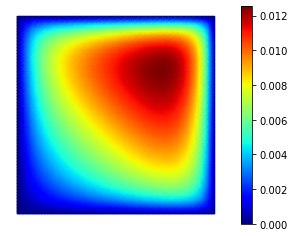

In [3]:
from skfem import *
from skfem.helpers import dot, grad
from skfem.visuals.matplotlib import plot

@BilinearForm
def laplace(u, v, _):
    b = 100 # можно менять
    return dot(grad(u), grad(v)) + b*u*v

@LinearForm
def rhs(v, w):
    x, y = w.x
    f = x + y # можно менять
    return f * v

# построение сетки и базиса конечных элементов
m = MeshTri().refined(6)
e = ElementTriP1()
basis = Basis(m, e)

# сборка и решение
A = laplace.assemble(basis)
b = rhs.assemble(basis)
A, b = enforce(A, b, D=m.boundary_nodes())
x = solve(A, b)

# график
plot(m, x, shading='gouraud', colorbar=True)